![alt text][logo]

[logo]: https://github.com/legolason/PyQSOFit/blob/master/pyqsofit/QSOFit_logo.png?raw=true


# PyQSOFit


PyQSOFit is a flexible tool to decompose quasar spectra. It was originally translated from [Yue Shen](http://quasar.astro.illinois.edu/)'s IDL qsofit code, but not exactly the same. With this program, people can get the information of quasar continuum and emission lines, e.g., continuum slope, line FWHM, line dispersion, EW, peak, etc. The main flows of this code are:

1) We decompose the host galaxy and quasar component with the PCA method if needed
2) We fit the continuum with several components (Power-Law, Polynomial, Fe II, Balmer Continuum) using some line free windows
3) We fit line complexes one by one, including H$\alpha$, H$\beta$, Mg II, C III], CIV and Ly$\alpha$ complex. In each complex, broad and narrow Gaussian profiles are used to fit different emission lines. 

For the details, you can read [Shen et al. (2015)](http://adsabs.harvard.edu/abs/2018arXiv181001447S), [Guo et al. (2018)](http://adsabs.harvard.edu/abs/2018arXiv180904610G) and Wang et al.(2018, in prepration)


## Installation and Requirements

To install this code, just download and install it with ``pip``:

``git clone https://github.com/legolason/PyQSOFit``<br>
``cd PyQSOFit``<br>
``python -m pip install .``<br>


This code was tested Python 3.9. These packages are __required__, but should have been installed automatically during the step above:

1) [Numpy](http://www.numpy.org/)<br>
2) [Scipy](https://www.scipy.org/)<br>
3) [Astropy](http://www.astropy.org/)<br>
4) [PyAstronomy](https://pyastronomy.readthedocs.io/en/latest/pyaCDoc/installingPyA.html)<br>
5) [LMFIT](https://lmfit.github.io/lmfit-py/)<br>
6) [Sfdmap](https://github.com/kbarbary/sfdmap): dust reddening map from [Schlegel et al. (2008)](http://www.adsabs.harvard.edu/abs/1998ApJ...500..525S), which can be downloaded [here](https://github.com/kbarbary/sfddata)<br>

These packages are __optional__. They are not installed automatically but must be installed for parameter uncertainty estimates:

1)  [emcee](https://emcee.readthedocs.io/en/stable/)<br>
2) [pandas](https://pandas.pydata.org/)<br>
3) [corner](https://corner.readthedocs.io/en/latest/)<br>

If using pPXF to get the host component (`use_ppxf=True`),

1) [pPXF](https://pypi.org/project/ppxf/)

Eigenspectra of galaxy and quasar from Yip et al. [(2004a)](http://adsabs.harvard.edu/abs/2004AJ....128..585Y), [(2004b)](http://adsabs.harvard.edu/abs/2004AJ....128.2603Y)
and Optical/UV Fe II templates are included in this package. We suggest that install python through [anaconda](https://www.anaconda.com/), which incorporates most packages you need.  

## Key features
1) Fit the whole spectra input or fit each line locally using ``wave_range`` parameter
2) Parameter uncertaianties can be computed for each parameter. The uncertainties from least-squares fitting is usually not robust, so we do not output those as default results (but the user still can read out this errors through ``lmfit.params``). The best way to calculate the error is using MCMC. In previous versions of the code, we used a Monte Carlo resampling method, which perturbs the flux based on the input error. Computing parameter uncertainties will take longer, but in practice we found that MCMC is not significantly slower than the resampling method and MCMC probably gives more reliable parameter uncertainties and covariances. 
3) A 3rd order polynomial component accounts for dust reddening if any.
4) Iterative sigma clipping can be used to clean the spectrum for absorbed continuum fitting. 
5) One can block serval ranges on the spectrum for bad S/N ratio pixels or absorption lines.
6) The code directly saves out the properties of emission lines, e.g., FWHM, line dispersion, EW, Peak, line flux for the broad components and continuum luminosity at 1350, 3000, 5100A.
7) One can remove the bad pixels caused by the cosmic ray or the sky. 
8) Host/QSO decompisition using built-in PCA method or pPXF.



## Possible future updates
1) Option for using Gauss-Hermite profile to fit the emission lines.<br>
2) Simultaneously fit several epochs for the same source since the time domain era is coming.<br>
3) Add functions to fit the absorption lines.<br>
4) Produce more secondary parameters from spectral fitting.<br>
5) Speed up the code by e.g., choosing better initial conditions (especially for the continuum and narrow-line flux normalizations).<br>
6) Option for automatically determining the number of broad emission line components to include in a fit using e.g., BIC. This will take longer to execute initially but might make the MCMC sampling faster and fits more reliable if fewer components are used, especially for low S/N or BAL quasar spectra.<br>
7) Improved integration with pPXF, specutils, etc.<br>
8) Better code documentation.<br>


## Authors
[Hengxiao Guo](https://hengxiaoguo.wixsite.com/hengxiaoguo), hengxiaoguo AT gmail.com (SHAO)<br>
[Yue Shen](http://quasar.astro.illinois.edu/), shenyue AT illinois.edu (UIUC)<br>
Shu Wang, wangshukiaa AT pku.edu.cn (Seoul National University)<br>
[Colin J. Burke](https://burke86.github.io/), colinjb2 AT illinois.edu (UIUC)<br>


## Acknowledgement
If our code makes your life easier, it would be appreciated to cite us:<br>
1) [Guo, H., Shen, Y., Wang, S. 2018, ascl:1809.008](https://ui.adsabs.harvard.edu/abs/2018ascl.soft09008G/abstract)
<br>
2) [Shen, Y. et al., ApJS, 241, 34S](http://adsabs.harvard.edu/abs/2018arXiv181001447S)


In [1]:
%matplotlib inline
import glob, os,sys,timeit
import matplotlib
import numpy as np
from pyqsofit.PyQSOFit import QSOFit
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

QSOFit.set_mpl_style()

In [2]:
# Show the versions so we know what works
import astropy
import lmfit
import pyqsofit
print(astropy.__version__)
print(lmfit.__version__)
print(pyqsofit.__version__)

import emcee # optional, for MCMC
print(emcee.__version__)


5.3.1
1.2.1
1.2.0
3.1.4


In [3]:
print(pyqsofit.__path__)


['/Users/wenke/data/20230710CodeRefine/20230710PyQSOFit/pyqsofit']


## Detailed Usage

## 1. Fit type 1 QSO

__Step 1: Set up the model input parameters__<br>
Firstly, run the script below to produce the line list file, qsopar.fits, containing lines and their constraints, which will be needed in the following fitting program. From this file, you can change some specific parameters to suit your requirements, e.g., fitting range, line width, tie line center, tie line sigma, etc. If you want to fit extra lines, please append it to corresponding complex. Note that our line wavelength and sigma in the list are in Ln scale, like Lnlambda, Lnsigma. 

In [7]:
#path_ex = '/Users/legolason/study/mesfit/v1.2/PyQSOFit/example/' # The absolute path to the example directory 
# path_ex = '/home/colinjb2/PyQSOFit/example'
path_ex = os.path.join(pyqsofit.__path__[0], '..', 'example')

# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Hengxiao Guo'
primary_hdu = fits.PrimaryHDU(header=hdr0)

In [8]:
"""
Create parameter file
lambda    complexname  minwav maxwav linename ngauss inisca minsca maxsca inisig minsig maxsig voff vindex windex findex fvalue vary
"""

newdata = np.rec.array([
(6564.61, 'Ha', 6400, 6800, 'Ha_br',   3, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.015, 0, 0, 0, 0.05 , 1),
(6564.61, 'Ha', 6400, 6800, 'Ha_na',   1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   0.0017, 0.01,  1, 1, 0, 0.002, 1),
(6549.85, 'Ha', 6400, 6800, 'NII6549', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 1, 0.001, 1),
(6585.28, 'Ha', 6400, 6800, 'NII6585', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 1, 0.003, 1),
(6718.29, 'Ha', 6400, 6800, 'SII6718', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 2, 0.001, 1),
(6732.67, 'Ha', 6400, 6800, 'SII6732', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 2, 0.001, 1),

(4862.68, 'Hb', 4640, 5100, 'Hb_br',     2, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.01, 0, 0, 0, 0.01 , 1),
(4862.68, 'Hb', 4640, 5100, 'Hb_na',     1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.002, 1),
(4960.30, 'Hb', 4640, 5100, 'OIII4959c', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.002, 1),
(5008.24, 'Hb', 4640, 5100, 'OIII5007c', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.004, 1),
#(4960.30, 'Hb', 4640, 5100, 'OIII4959w',   1, 0.1, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.001, 1),
#(5008.24, 'Hb', 4640, 5100, 'OIII5007w',   1, 0.1, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.002, 1),
#(4687.02, 'Hb', 4640, 5100, 'HeII4687_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.001, 1),
#(4687.02, 'Hb', 4640, 5100, 'HeII4687_na', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.005, 1, 1, 0, 0.001, 1),

#(3934.78, 'CaII', 3900, 3960, 'CaII3934' , 2, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 99, 0, 0, -0.001, 1),

#(3728.48, 'OII', 3650, 3800, 'OII3728', 1, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 1, 1, 0, 0.001, 1),

#(3426.84, 'NeV', 3380, 3480, 'NeV3426',    1, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 0, 0, 0, 0.001, 1),
#(3426.84, 'NeV', 3380, 3480, 'NeV3426_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025,   0.02,   0.01, 0, 0, 0, 0.001, 1),

(2798.75, 'MgII', 2700, 2900, 'MgII_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
(2798.75, 'MgII', 2700, 2900, 'MgII_na', 2, 0.1, 0.0, 1e10, 1e-3, 5e-4, 0.0017, 0.01, 1, 1, 0, 0.002, 1),

(1908.73, 'CIII', 1700, 1970, 'CIII_br',   2, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 99, 0, 0, 0.01, 1),
#(1908.73, 'CIII', 1700, 1970, 'CIII_na',   1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01,  1, 1, 0, 0.002, 1),
#(1892.03, 'CIII', 1700, 1970, 'SiIII1892', 1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
#(1857.40, 'CIII', 1700, 1970, 'AlIII1857', 1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
#(1816.98, 'CIII', 1700, 1970, 'SiII1816',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
#(1786.7,  'CIII', 1700, 1970, 'FeII1787',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
#(1750.26, 'CIII', 1700, 1970, 'NIII1750',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),
#(1718.55, 'CIII', 1700, 1900, 'NIV1718',   1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),

(1549.06, 'CIV', 1500, 1700, 'CIV_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05,   0.015, 0, 0, 0, 0.05 , 1),
(1549.06, 'CIV', 1500, 1700, 'CIV_na', 1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01,  1, 1, 0, 0.002, 1),
#(1640.42, 'CIV', 1500, 1700, 'HeII1640',    1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   0.0017, 0.008, 1, 1, 0, 0.002, 1),
#(1663.48, 'CIV', 1500, 1700, 'OIII1663',    1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   0.0017, 0.008, 1, 1, 0, 0.002, 1),
#(1640.42, 'CIV', 1500, 1700, 'HeII1640_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),
#(1663.48, 'CIV', 1500, 1700, 'OIII1663_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),

#(1402.06, 'SiIV', 1290, 1450, 'SiIV_OIV1', 1, 0.1, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
#(1396.76, 'SiIV', 1290, 1450, 'SiIV_OIV2', 1, 0.1, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
#(1335.30, 'SiIV', 1290, 1450, 'CII1335',   1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),
#(1304.35, 'SiIV', 1290, 1450, 'OI1304',    1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),

(1215.67, 'Lya', 1150, 1290, 'Lya_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05,   0.02, 0, 0, 0, 0.05 , 1),
(1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01, 0, 0, 0, 0.002, 1)],

formats = 'float32,      a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32,   float32, int32',
names  =  ' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,  voff,     vindex, windex,  findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the line parameters (set to 0 to fix the line parameters to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=newdata, header=hdr1, name='data')

In [9]:
"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[1350, 1450, 3000, 4200, 5100]],
        [[[2240, 2650], [4435, 4685]]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr2 = fits.Header()
hdr2['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr2['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu2 = fits.BinTableHDU(data=measure_info, header=hdr2, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2])
hdu_list.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

__Print the table:__

In [6]:
from astropy.table import Table
Table(newdata)

lambda,compname,minwav,maxwav,linename,ngauss,inisca,minsca,maxsca,inisig,minsig,maxsig,voff,vindex,windex,findex,fvalue,vary
float32,bytes20,float32,float32,bytes20,int32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,int32
6564.61,H$\alpha$,6400.0,6800.0,Ha_br,3,0.1,0.0,10000000000.0,0.005,0.004,0.05,0.015,0,0,0,0.05,1
6564.61,H$\alpha$,6400.0,6800.0,Ha_na,1,0.1,0.0,10000000000.0,0.001,0.0005,0.0017,0.01,1,1,0,0.002,1
6549.85,H$\alpha$,6400.0,6800.0,NII6549,1,0.1,0.0,10000000000.0,0.001,0.00023,0.0017,0.005,1,1,1,0.001,1
6585.28,H$\alpha$,6400.0,6800.0,NII6585,1,0.1,0.0,10000000000.0,0.001,0.00023,0.0017,0.005,1,1,1,0.003,1
6718.29,H$\alpha$,6400.0,6800.0,SII6718,1,0.1,0.0,10000000000.0,0.001,0.00023,0.0017,0.005,1,1,2,0.001,1
6732.67,H$\alpha$,6400.0,6800.0,SII6732,1,0.1,0.0,10000000000.0,0.001,0.00023,0.0017,0.005,1,1,2,0.001,1
4862.68,H$\beta$,4640.0,5100.0,Hb_br,2,0.1,0.0,10000000000.0,0.005,0.004,0.05,0.01,0,0,0,0.01,1
4862.68,H$\beta$,4640.0,5100.0,Hb_na,1,0.1,0.0,10000000000.0,0.001,0.00023,0.0017,0.01,1,1,0,0.002,1
4960.3,H$\beta$,4640.0,5100.0,OIII4959c,1,0.1,0.0,10000000000.0,0.001,0.00023,0.0017,0.01,1,1,0,0.002,1


Note: if you want to tie the line properties in different complex, you can enlarge the complex range.

__Step 2: Read the spectrum__ <br>
Setup the paths and read in your spectrum. Our code is written under the frame of SDSS spectral data format. Other data is also available as long as they include wavelength, flux, error, and redshift, and make sure the wavelength resolution is the same as SDSS spectrum (For SDSS the pixel scale is 1.e-4 in log space).

In [7]:
#path_out = '/Users/legolason/study/mesfit/v1.2/PyQSOFit/example/data/' # path of fitting results
# path_out = '/home/colinjb2/PyQSOFit/example/data/'
path_out = os.path.join(pyqsofit.__path__[0], '../', 'example/data/')

# Requried
data = fits.open(os.path.join(path_ex, 'data/spec-0332-52367-0639.fits'))
lam = 10**data[1].data['loglam']        # OBS wavelength [A]
flux = data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
err = 1/np.sqrt(data[1].data['ivar'])   # 1 sigma error
z = data[2].data['z'][0]                # Redshift


# Optional
ra = data[0].header['plug_ra']        # RA
dec = data[0].header['plug_dec']      # DEC
plateid = data[0].header['plateid']   # SDSS plate ID
mjd = data[0].header['mjd']           # SDSS MJD
fiberid = data[0].header['fiberid']   # SDSS fiber ID

__Step 3: Fit the spectrum__<br>
Use QSOFit to input the lam, flux, err, z, and other optinal parameters. Use function Fit to perform the fitting. Default settings cannot meet all needs. Please change settings for your own requirements. It depends on what science you need. The following example set dereddening, host decomposition to True.

The ``broad_fwhm`` parameter can be adjusted depending on your definition (default is 1200 km s$^{-1}$).

install path: /Users/wenke/data/20230710CodeRefine/20230710PyQSOFit/pyqsofit
Fitting finished in 0.5s


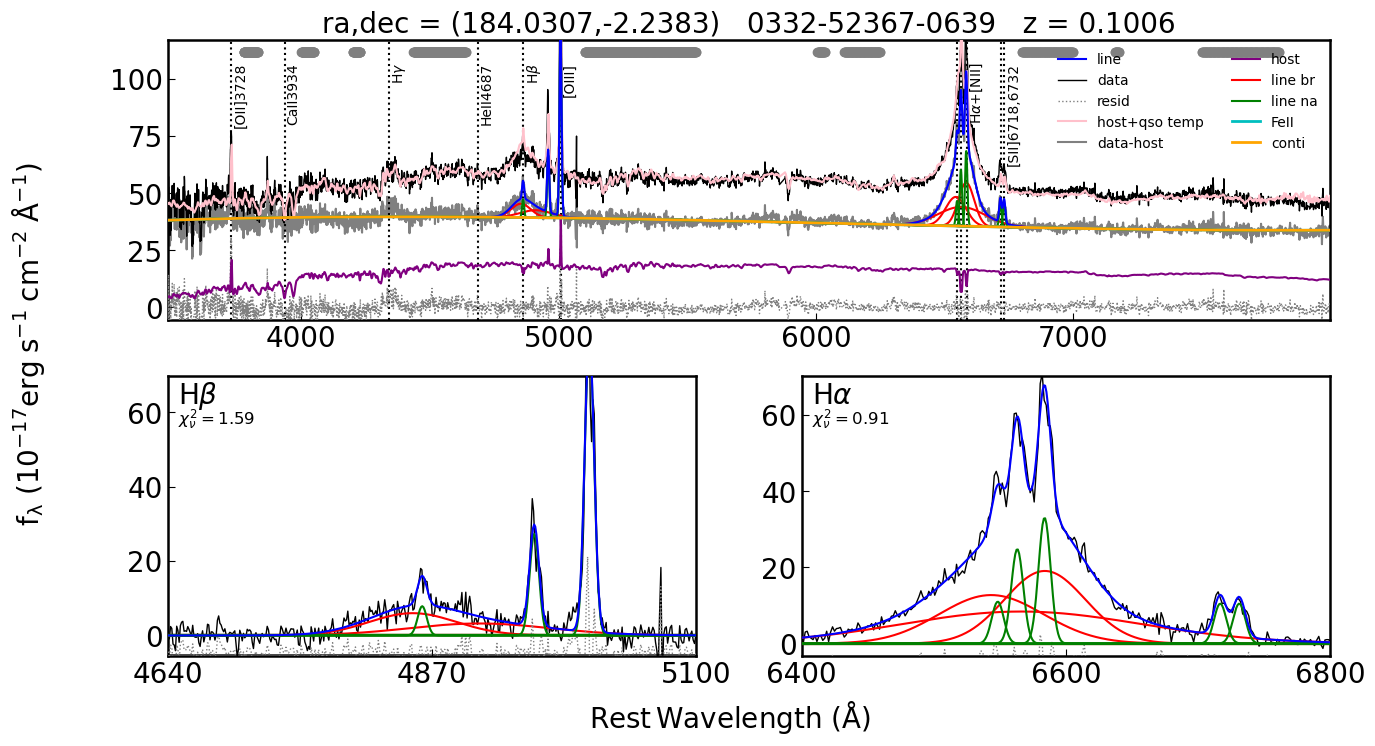

In [9]:
# Prepare data
q_mle = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

# Double check the installation path with the PCA / Fe template files
print('install path:', q_mle.install_path)
# Change it if you installed them somewhere else
#q_mle.install_path = '...'

start = timeit.default_timer()
# Do the fitting
q_mle.Fit(name=None, nsmooth=1, deredden=True, reject_badpix=False, wave_range=None, \
          wave_mask=None, decompose_host=True, BC03=False, npca_gal=5, npca_qso=10, Fe_uv_op=False, \
          poly=True, BC=False, rej_abs_conti=False, rej_abs_line=False, linefit=True, save_result=True, save_fig=False, \
          kwargs_plot={'save_fig_path':'.', 'broad_fwhm':1200}, save_fits_path=path_out, verbose=False)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

The gray shaded bars at the top are the continuum windows used in the fitting.<br>
__Now you are already done with the QSO fitting part!__

__Step 3(optional): Compute parameter unertaintines using MC resampling__:<br>
For comparison, let's fit the same quasar spectrum, but this time using MC resampling of the spectrum based on the spectrum error. Obviously, this will take significantly longer depending on the number of samples you want to run `nsamp`. 

Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
Balmer_Tau        0.5      0.1        2     None    False     None     None
Balmer_Te     1.5e+04    1e+04    5e+04     None    False     None     None
Blamer_norm         0        0    1e+10     None    False     None     None
Fe_op_FWHM       3000     1200  1.8e+04     None     True     None     None
Fe_op_norm          1        0    1e+10     None     True     None     None
Fe_op_shift         0    -0.01     0.01     None     True     None     None
Fe_uv_FWHM       3000     1200  1.8e+04     None    False     None     None
Fe_uv_norm          0        0    1e+10     None    False     None     None
Fe_uv_shift         0    -0.01     0.01     None    False     None     None
PL_norm             1        0    1e+10     None     True     None     None
PL_slope         -1.5       -5        3     None     True     None     None
conti_pl_0          0     -inf      inf     None     True     None     None
conti_pl_1

AttributeError: 'Figure' object has no attribute 'close'

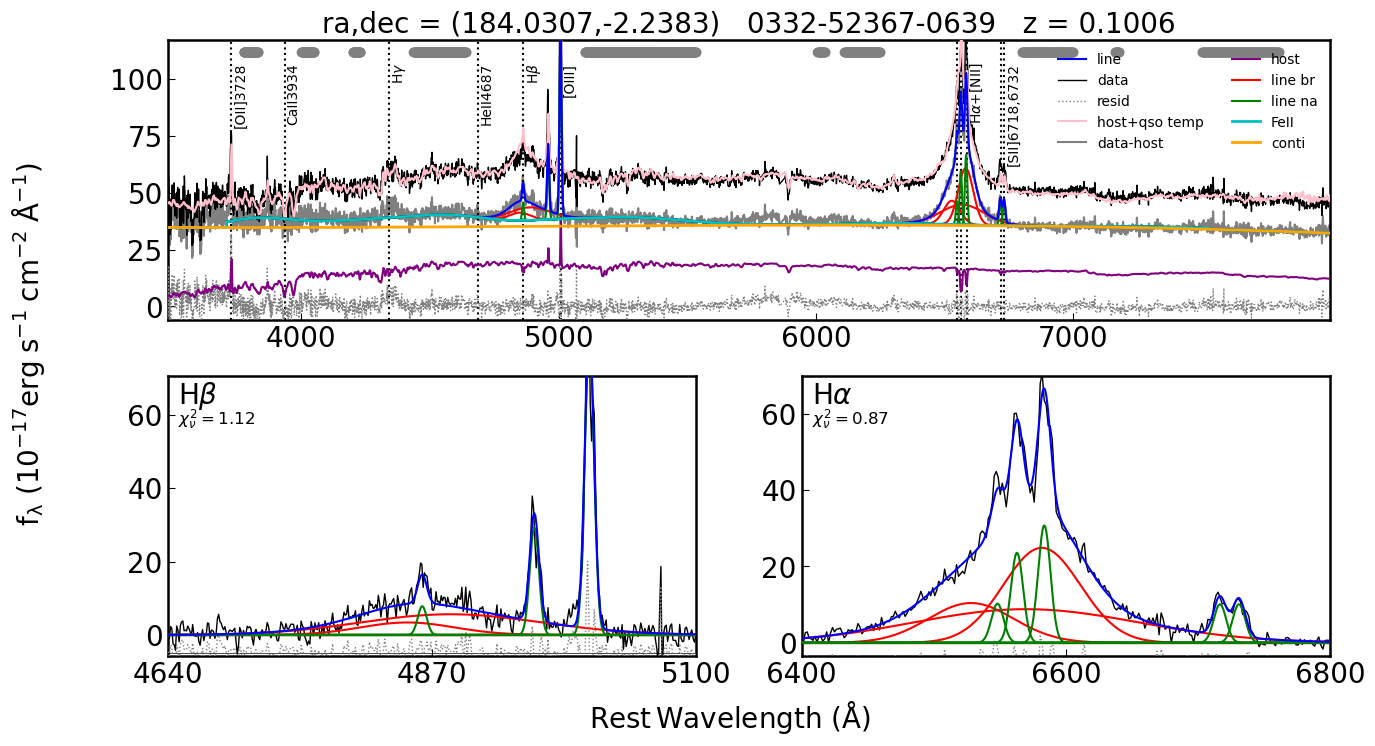

In [10]:
q_mc = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

start = timeit.default_timer()
# Do the fitting

q_mc.Fit(name=None, nsmooth=1, deredden=True, reject_badpix=False, wave_range=None, \
      wave_mask=None, decompose_host=True, BC03=False, npca_gal=5, npca_qso=10, \
      Fe_uv_op=True, poly=True, rej_abs_conti=False, rej_abs_line=True, MC=True, nsamp=200, linefit=True, \
      save_result=True, kwargs_plot={'save_fig_path':'.'}, save_fits_name=None, verbose=True)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

__Step 3(optional): Compute parameter unertaintines using MCMC__:<br>
For comparison, let's fit the same quasar spectrum, but this time using MCMC to get uncertainties on the parameters. Obviously, this will take significantly longer depending on the number of samples you want to run. You will need the ``pandas`` and ``emcee`` packages to do this. To visualize the posterior parameter distributions and their covariances, you will need the ``corner`` package. It's also usually a good idea to perturb the parameter starting points by a small random number using the ``epsilon_jitter`` argument, and exclude unnecessary line components, otherwise you may get an ''Initial state has a large condition number'' error.

In [ ]:
q_mcmc = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

start = timeit.default_timer()
# Do the fitting
q_mcmc.Fit(name=None, nsmooth=1, deredden=True, reject_badpix=False, wave_range=None, \
      wave_mask=None, decompose_host=True, npca_gal=5, npca_qso=10, Fe_uv_op=True, poly=True, rej_abs_conti=False, \
      MCMC=True, epsilon_jitter= 1e-4, nburn=100, nsamp=200, nthin=10, linefit=True, save_result=True, \
      plot_fig=True, save_fig=False, plot_corner=True, kwargs_plot={'save_fig_path':'.'}, save_fits_name=None, verbose=False)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

When ``MCMC=True`` or ``MC=True`` (they cannot both be ``True``), the 1$\sigma$ uncertainties (from the 16th and 84th percentiles) are added to the results (the "_err" parameters). The initial MLE fit will again be computed and is used as the starting point for emcee.

You may need to turn off/on continuum fitting components or adjust the parameter bounds as neccessary to fit your data. From the above plots, it is clear that the parameter posteriors are reasonably well-constrained. For more details, such as to view the acceptance fraction, use ``verbose=True``.

__View results:__ The results arrays will include the uncertainties on each parameter only if MCMC is used.

In [ ]:
# Continuum fitting results
print(q_mcmc.conti_result_name)
print('')
print(q_mcmc.conti_result)

In [ ]:
# Gaussian fitting results
print(q_mcmc.gauss_result_name)
print('')
print(q_mcmc.gauss_result)

To get the results of each MC or MCMC sample, use ``gauss_result_all``. You can then use the ``line_prop`` function to get the line properties for each sample, and take median values of each parameter's samples. The parameters in ``gauss_result`` are used for the MLE solution for MCMC (or just one MC sample), and may not be the same as the median of the posterior distributions!

In [ ]:
# Gaussian fitting results
print(q_mcmc.gauss_result_name[::2])
print('')
print(q_mcmc.gauss_result_all)
print(np.shape(q_mcmc.gauss_result_all))

In [ ]:
# line fitting results
print(q_mcmc.line_result_name)
print('')
print(q_mcmc.line_result)

__Step 4: Get all models for the whole spectrum__ <br>
Continue to look at this section and below if you want to do some further calculations based on the fitting results. Here, we show how to extract different models from our fitting results, such as continuum model, emission line models and host galaxy component. Note that the emission regions of host galaxy template should be blocked, e.g., H$\alpha$ [6540, 6590].

There are two ways to calculate the Fe II flux within given ranges:
1. If you want the program calculate the Fe II flux automatically and documented them in result file, you can use the parameter `Fe_flux_range` in `Fit()` to assign ranges.
2. We also provide build-in function `Get_Fe_flux` to calculate the Fe II flux directly after you finished the fitting part.

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

# Plot the quasar rest frame spectrum after removed the host galaxy component
ax.plot(q_mcmc.wave, q_mcmc.flux, 'grey',label='Data')
ax.plot(q_mcmc.wave, q_mcmc.err, 'r',label='Error')

# Skip the error results before plotting
if q_mcmc.MCMC == True:
    gauss_result = q_mcmc.gauss_result[::2]
else:
    gauss_result = q_mcmc.gauss_result


# To plot the whole model, we use Manygauss to show the line fitting results saved in gauss_result
ax.plot(q_mcmc.wave, q_mcmc.Manygauss(np.log(q_mcmc.wave), gauss_result) + q_mcmc.f_conti_model, 'b', label='Line', lw=2)
ax.plot(q_mcmc.wave, q_mcmc.f_conti_model, 'c', lw=2,label='Continuum+FeII')
ax.plot(q_mcmc.wave, q_mcmc.PL_poly_BC, 'orange', lw=2,label='Continuum')
ax.plot(q_mcmc.wave, q_mcmc.host, 'm', lw=2,label='Host')
plt.legend()

ax.set_xlim(3500, 8000)
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

#print('optical Fe flux (10^(-17) erg/s/cm^2): ' + q_mcmc.conti_result[q_mcmc.conti_result_name=='Fe_flux_4435_4685'][0])

Fe_flux_result, Fe_flux_type, Fe_flux_name = q_mcmc.Get_Fe_flux(np.array([4400,4900]))
print('Fe flux within a specific range: \n'+Fe_flux_name[0]+': '+str(Fe_flux_result[0]))


__Step 5: Get models for each line complex__ <br>
All the line parameters are in the gauss_result, it was saved following the order of ``qsopar.fits``. For each Gaussian, three parameter (scale, ln lambda, ln sigma) are saved.
If you want to filter the line below or above 1200 km/s (ln sigma = 0.0017), the function ``CalFWHM`` can be used as following.

The line_prop is designed to calculate the broad line properties, not for the narrow line. It is saved in the line_result property, but can be computed again.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

if q_mcmc.MCMC:
    gauss_result = q_mcmc.gauss_result[::2]
else:
    gauss_result = q_mcmc.gauss_result

# Plot individual line components
for p in range(int(len(gauss_result)/3)):
    if q_mcmc.CalFWHM(gauss_result[3*p+2]) < 1200:  # < 1200 km/s narrow
        color = 'g' # narrow
    else:
        color = 'r' # broad
    ax.plot(q_mcmc.wave, q_mcmc.Onegauss(np.log(q_mcmc.wave), gauss_result[p*3:(p+1)*3]), color=color)

# Plot total line model
ax.plot(q_mcmc.wave, q_mcmc.Manygauss(np.log(q_mcmc.wave), gauss_result), 'b', lw=2)
ax.plot(q_mcmc.wave, q_mcmc.line_flux,'k')
ax.set_xlim(4640, 5100)
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize = 20)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize = 20)


"""
Line properties
"""

# The line_prop function is used to calculate the broad line properties
# (defined, by default, as ln sigma > 0.0017 (1200 km/s) )

# OLD WAY: If you want to calculate the paramters of broad Hb
# then find all the broad Hb component, i.e., Hb_br_[1,2,3]_[scale,centerwave,sigma]
# for here q.line_result_name[12:15], q.line_result[12:15] is the broad Hb
# If MCMC=False, this would be:
# fwhm, sigma, ew, peak, area = q.line_prop(q.linelist[6][0], q.line_result[12:15], 'broad')

# NEW WAY: using line_prop_from_name convenience function
fwhm, sigma, ew, peak, area = q_mcmc.line_prop_from_name('Hb_br', 'broad')

print("Broad Hb:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")


# OLD WAY: If you want to calculate the  the narrow [OIII]5007
# If MCMC=False, this would be:
# the coresponding parameters are  q.line_result_name[21:24], q.line_result[21:24]
# fwhm, sigma, ew, peak, area = q.line_prop(q.linelist[6][0], q.line_result[21:24], 'narrow')

fwhm, sigma, ew, peak, area = q_mcmc.line_prop_from_name('OIII5007c', 'narrow')

print("Narrow [OIII]5007:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))

__Determine number of broad components for a line__:

If you want to determine how many Gaussian components are statistically justified for a broad emission line given the S/N, run ``PyQSOFit`` multiple times and use the [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) to determine it.

In [ ]:
#path_out = '/Users/legolason/study/mesfit/v1.2/PyQSOFit/example/data/' # path of fitting results

# Required
data = fits.open(os.path.join(path_ex, 'data/spec-0332-52367-0639.fits'))
lam = 10**data[1].data['loglam']        # OBS wavelength [A]
flux = data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
err = 1/np.sqrt(data[1].data['ivar'])   # 1 sigma error
z = data[2].data['z'][0]                # Redshift

# Optional
ra = data[0].header['plug_ra']        # RA
dec = data[0].header['plug_dec']      # DEC
plateid = data[0].header['plateid']   # SDSS plate ID
mjd = data[0].header['mjd']           # SDSS MJD
fiberid = data[0].header['fiberid']   # SDSS fiber ID


ngauss_max = 5 # stop at 5 components
bic_last = np.inf

# Number of Gaussians to try loop
for ngauss in range(1, ngauss_max):

    print(fr'Fitting broad H$\alpha$ with {ngauss} components.')

    # Change the number of Gaussians for the Ha line in the line parameter file
    newdata_n = newdata.copy()

    for i, row in enumerate(newdata_n):
        if 'Ha_br' in str(row['linename']):
            newdata_n[i]['ngauss'] = ngauss

    hdu = fits.BinTableHDU(data=newdata_n, header=hdr, name='data')
    hdu.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

    # Do the fitting
    q = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

    q.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None, \
          wave_mask=None, decompose_host=True, npca_gal=5, npca_qso=10, \
          Fe_uv_op=True, poly=True, BC=False, rej_abs=False, \
          initial_guess=None, MCMC=False, nburn=20, nsamp=200, nthin=10, linefit=True, \
          save_result=False, plot_fig=False, verbose=False)

    mask_Ha_bic = q.line_result_name == '2_line_min_chi2'

    bic = float(q.line_result[mask_Ha_bic][0])

    print(f'Delta BIC = {np.round(bic_last - bic, 1)}')

    # Stop condition of Delta BIC = 10 is a good rule of thumb
    if bic_last - bic < 10:
        break

    bic_last = bic

    # Plot the result
    if q.MCMC:
        gauss_result = q.gauss_result[::2]
    else:
        gauss_result = q.gauss_result

    fig, ax = plt.subplots(1, 1, figsize=(8,5))

    # Plot individual line components
    for p in range(len(gauss_result)//3):
        if q.CalFWHM(gauss_result[3*p+2]) < 1200:  # < 1200 km/s narrow
            color = 'g' # narrow
        else:
            color = 'r' # broad
        ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p*3:(p+1)*3]), color=color)

    # Plot total line model
    ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=2)
    ax.plot(q.wave, q.line_flux,'k')
    ax.set_xlim(6400, 6800)
    ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
    ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

    c = 1 # Ha
    ax.text(0.02, 0.80, r'$\chi ^2_\nu=$'+str(np.round(float(q.comp_result[c*7+4]), 2)),
                               fontsize=16, transform=ax.transAxes)

    plt.show()

__Multiproccessing example:__ <br>
Uncertainty computation will cost some time, so we always use the multiprocessing to speed up fitting a large sample of many quasar spectra. 

We note that running multiprocessing on jupyter notebook may lead to various errors depending on the environment. The example here is only tested in MacOS Big Sur 11.2 with python 3.8.5. Running multiprocessing in non-interactive interpreters is recommended. For more information see https://docs.python.org/3/library/multiprocessing.html

*Memory leak warning*: For the convenience of display, the code wouldn't close the figure automatically which could lead to memory leak by child process if one uses multiprocessing. Considering the common memory size of modern computer is relatively large, dealing with a small amount of spectrum (say, less than 100) at a time is acceptable and those occupied memory would be released once the main process ends. However, if one needs to handle more spectrum, one can add `plt.close()` at the end of the function `QSOFit._PlotFig` in `PyQSOFit.py` or at the child process after spectrum are fitted (`import matplotlib.pyplot as plt` is also needed).

In [ ]:
def job(file):

    print(file + '\n')

    data = fits.open(file)

    lam = 10**data[1].data['loglam']
    flux = data[1].data['flux']
    err = 1/np.sqrt(data[1].data['ivar'])
    ra = data[0].header['plug_ra']
    dec = data[0].header['plug_dec']
    z = data[2].data['z'][0]
    plateid = data[0].header['plateid']
    mjd = data[0].header['mjd']
    fiberid = data[0].header['fiberid']

    q = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

    q.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None, wave_mask=None,
          decompose_host=True, npca_gal=5, npca_qso=20, Fe_uv_op=True, poly=True, BC=False, rej_abs=False,
          MCMC=False, plot_fig=True, save_fig=True, save_fits_path=path_out, save_fits_name=None, verbose=False)


In [ ]:
# Edit the directory before use
from multiprocessing import Pool
import os, timeit, glob

if __name__ == '__main__':
    start = timeit.default_timer()
    
    files = glob.glob(os.path.join(path_ex, 'data/spec-*.fits'))
    
    pool = Pool() # Create a multiprocessing Pool
    pool.map(job, files)
    
    end = timeit.default_timer()
    print(f'Fitting finished in : {np.round(end - start)}s')



### 2. Fit emission line galaxy
This code can also fit emission line galaxies.

In [ ]:
# Remove the broad components from the line parameter file 
mask_na = [True if not '_br' in str(row['linename']) else False for row in newdata]
# Or you can set broad component number to zero

# Save line info
hdu = fits.BinTableHDU(data=newdata[mask_na], header=hdr, name='data')
hdu.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

In [ ]:
data = fits.open(os.path.join(path_ex, 'data/spec-0266-51602-0107.fits'))
lam = 10**data[1].data['loglam']        # OBS wavelength [A]
flux = data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
err = 1/np.sqrt(data[1].data['ivar'])   # 1 sigma error
z = data[2].data['z'][0]                # Redshift


# Optional
ra = data[0].header['plug_ra']          # RA 
dec = data[0].header['plug_dec']        # DEC
plateid = data[0].header['plateid']     # SDSS plate ID
mjd = data[0].header['mjd']             # SDSS MJD
fiberid = data[0].header['fiberid']     # SDSS fiber ID


q = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

q.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None,\
      wave_mask=None, decompose_host=True, npca_gal=5, npca_qso=10,\
      Fe_uv_op=False, poly=False, BC=False, rej_abs=False, MCMC=False, \
      save_result=True, plot_fig=True, save_fig=False, plot_line_name=True, plot_legend=True, \
      save_fig_path=path_out, save_fits_path=path_out, save_fits_name=None)

### 3. Fit normal galaxy
From the fitting, we can get the host galaxy component using PyQSOFit's PCA decomposition. Then we can use [pPXF](http://www-astro.physics.ox.ac.uk/~mxc/software/) to get the velocity dispersion and starformation history.

In [ ]:
data = fits.open(os.path.join(path_ex, 'data/spec-0266-51602-0013.fits'))
lam = 10**data[1].data['loglam']        # OBS wavelength [A]
flux = data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
err = 1/np.sqrt(data[1].data['ivar'])   # 1 sigma error
z = data[2].data['z'][0]                # Redshift

# Optional
ra = data[0].header['plug_ra']          # RA 
dec = data[0].header['plug_dec']        # DEC
plateid = data[0].header['plateid']     # SDSS plate ID
mjd = data[0].header['mjd']             # SDSS MJD
fiberid = data[0].header['fiberid']     # SDSS fiber ID


q = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

q.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None,\
      wave_mask=None, decompose_host=True, npca_gal=5, npca_qso=10, linefit=False, \
      Fe_uv_op=False, poly=False, BC=False, rej_abs=False, MCMC=False, \
      save_result=True, plot_fig=True, save_fig=False, plot_line_name=True, plot_legend=True, \
      save_fig_path=path_out, save_fits_path=path_out, save_fits_name=None)